개인 프로젝트(2주간)
주어진 데이터셋 중 원하는 데이터셋을 사용해 원하는 사전 훈련 모델(CNN)을 훈련시키고, 연구보고서를 작성해 보세요.
(선택은 3월 19일 수요일 13시까지)
- (필수) Test Accuracy, Test Loss 출력 값과 성능 시각화(그래프)를 포함한 연구 및 분석 과정에 대한 내용이 있어야합니다.
- (선택) 위 성공 조건을 달성했다면. 실제 데이터를 입력해 예측 또는 분류 결과 출력 후 분석한 내용도 작성해보세요.
- (예고) DB 연동(중간발표후)

In [1]:
# 구글 코랩에서 데이터셋 다운로드 및 준비
from google.colab import files
files.upload()  # 'kaggle.json' 파일 업로드

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# fruit-and-vegetable 데이터셋 다운로드
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
License(s): CC0-1.0


In [2]:
# 압축 해제
!unzip /content/fruit-and-vegetable-image-recognition.zip -d fruit-and-vegetable

Archive:  /content/fruit-and-vegetable-image-recognition.zip
  inflating: fruit-and-vegetable/test/apple/Image_1.jpg  
  inflating: fruit-and-vegetable/test/apple/Image_10.jpg  
  inflating: fruit-and-vegetable/test/apple/Image_2.jpg  
  inflating: fruit-and-vegetable/test/apple/Image_3.jpg  
  inflating: fruit-and-vegetable/test/apple/Image_4.jpg  
  inflating: fruit-and-vegetable/test/apple/Image_5.jpg  
  inflating: fruit-and-vegetable/test/apple/Image_6.JPG  
  inflating: fruit-and-vegetable/test/apple/Image_7.jpg  
  inflating: fruit-and-vegetable/test/apple/Image_8.jpg  
  inflating: fruit-and-vegetable/test/apple/Image_9.jpg  
  inflating: fruit-and-vegetable/test/banana/Image_1.jpg  
  inflating: fruit-and-vegetable/test/banana/Image_10.jpg  
  inflating: fruit-and-vegetable/test/banana/Image_2.jpg  
  inflating: fruit-and-vegetable/test/banana/Image_3.jpg  
  inflating: fruit-and-vegetable/test/banana/Image_4.jpg  
  inflating: fruit-and-vegetable/test/banana/Image_5.jpg  
  i

In [3]:
# 데이터셋 파일 목록 출력
import os

# 이미지 파일이 들어있는 디렉토리 경로
data_dir = '/content/fruit-and-vegetable'

# 파일 목록 출력
for root, dirs, files in os.walk(data_dir):
    for file in files:
        print(os.path.join(root, file))

/content/fruit-and-vegetable/test/watermelon/Image_3.jpg
/content/fruit-and-vegetable/test/watermelon/Image_9.jpg
/content/fruit-and-vegetable/test/watermelon/Image_7.jpg
/content/fruit-and-vegetable/test/watermelon/Image_8.jpg
/content/fruit-and-vegetable/test/watermelon/Image_1.jpg
/content/fruit-and-vegetable/test/watermelon/Image_4.jpg
/content/fruit-and-vegetable/test/watermelon/Image_5.jpg
/content/fruit-and-vegetable/test/watermelon/Image_2.jpg
/content/fruit-and-vegetable/test/watermelon/Image_6.jpg
/content/fruit-and-vegetable/test/watermelon/Image_10.jpg
/content/fruit-and-vegetable/test/lettuce/Image_3.jpg
/content/fruit-and-vegetable/test/lettuce/Image_5.jpeg
/content/fruit-and-vegetable/test/lettuce/Image_9.jpg
/content/fruit-and-vegetable/test/lettuce/Image_7.jpg
/content/fruit-and-vegetable/test/lettuce/Image_8.jpg
/content/fruit-and-vegetable/test/lettuce/Image_1.jpg
/content/fruit-and-vegetable/test/lettuce/Image_4.jpg
/content/fruit-and-vegetable/test/lettuce/Image_2.

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import datetime

In [5]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 로드
trainset = ImageFolder(root='/content/fruit-and-vegetable/train', transform=transform)
valset = ImageFolder(root='/content/fruit-and-vegetable/validation', transform=transform)
testset = ImageFolder(root='/content/fruit-and-vegetable/test', transform=transform)

# DataLoader 생성
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=8)
valloader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=8)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=8)

# 클래스 확인
print(f"클래스 인덱스: {trainset.class_to_idx}")
class_names = list(trainset.class_to_idx.keys())

클래스 인덱스: {'apple': 0, 'banana': 1, 'beetroot': 2, 'bell pepper': 3, 'cabbage': 4, 'capsicum': 5, 'carrot': 6, 'cauliflower': 7, 'chilli pepper': 8, 'corn': 9, 'cucumber': 10, 'eggplant': 11, 'garlic': 12, 'ginger': 13, 'grapes': 14, 'jalepeno': 15, 'kiwi': 16, 'lemon': 17, 'lettuce': 18, 'mango': 19, 'onion': 20, 'orange': 21, 'paprika': 22, 'pear': 23, 'peas': 24, 'pineapple': 25, 'pomegranate': 26, 'potato': 27, 'raddish': 28, 'soy beans': 29, 'spinach': 30, 'sweetcorn': 31, 'sweetpotato': 32, 'tomato': 33, 'turnip': 34, 'watermelon': 35}


In [ ]:
def visualize_classes(dataset, num_images=36):
    # 클래스별 대표 이미지 저장을 위한 딕셔너리
    class_images = {}

    # 데이터 로드 및 각 클래스별 이미지 1개씩 저장
    for image, label in dataset:
        class_name = dataset.classes[label]
        if class_name not in class_images:
            class_images[class_name] = image
        if len(class_images) == num_images:  # 36개 채워지면 종료
            break

    # 시각화 (6x6 그리드)
    plt.figure(figsize=(12, 12))
    for idx, (class_name, image) in enumerate(class_images.items()):
        plt.subplot(6, 6, idx + 1)
        img = image.permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)

        # 정규화 해제 (ImageNet 정규화 되돌리기)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.title(class_name, fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 시각화 실행
visualize_classes(trainset)


KeyboardInterrupt: 

### Resnet18, VGG16, fine tuning에 따라 모델 학습

In [6]:
# 경고 제거
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # UserWarning을 끔

In [7]:
# VGG16 모델 불러오기 (pretrained=True로 사전 훈련된 가중치 사용)
vgg16_model = models.vgg16(pretrained=True)

# # 모델 아키텍처 출력
# vgg16_model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 205MB/s]


In [8]:
# resnet18 모델 불러오기 (pretrained=True로 사전 훈련된 가중치 사용)
resnet18_model = models.resnet18(pretrained=True)

# # 모델 아키텍처 출력
# resnet18_model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 227MB/s]


Training resnet18 - Feature Extraction
Epoch [1/20]
Train Loss: 2.3758, Train Accuracy: 43.88%
Val Loss: 1.0130, Val Accuracy: 81.77%
Model saved as resnet18_feature_extraction.pth
Epoch [2/20]
Train Loss: 1.1681, Train Accuracy: 73.71%
Val Loss: 0.5835, Val Accuracy: 86.61%
Model saved as resnet18_feature_extraction.pth
Epoch [3/20]
Train Loss: 0.8629, Train Accuracy: 79.39%
Val Loss: 0.4584, Val Accuracy: 88.89%
Model saved as resnet18_feature_extraction.pth
Epoch [4/20]
Train Loss: 0.7125, Train Accuracy: 82.47%
Val Loss: 0.3780, Val Accuracy: 92.02%
Model saved as resnet18_feature_extraction.pth
Epoch [5/20]
Train Loss: 0.6170, Train Accuracy: 84.78%
Val Loss: 0.3399, Val Accuracy: 92.31%
Model saved as resnet18_feature_extraction.pth
Epoch [6/20]
Train Loss: 0.5500, Train Accuracy: 86.10%
Val Loss: 0.3059, Val Accuracy: 92.02%
Model saved as resnet18_feature_extraction.pth
Epoch [7/20]
Train Loss: 0.5024, Train Accuracy: 87.09%
Val Loss: 0.2884, Val Accuracy: 90.60%
Model saved as

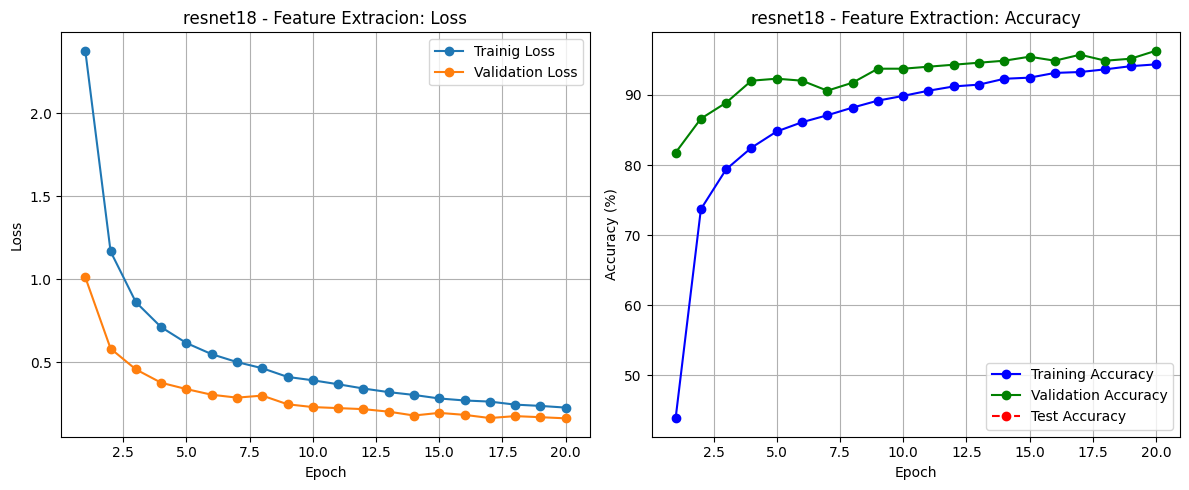

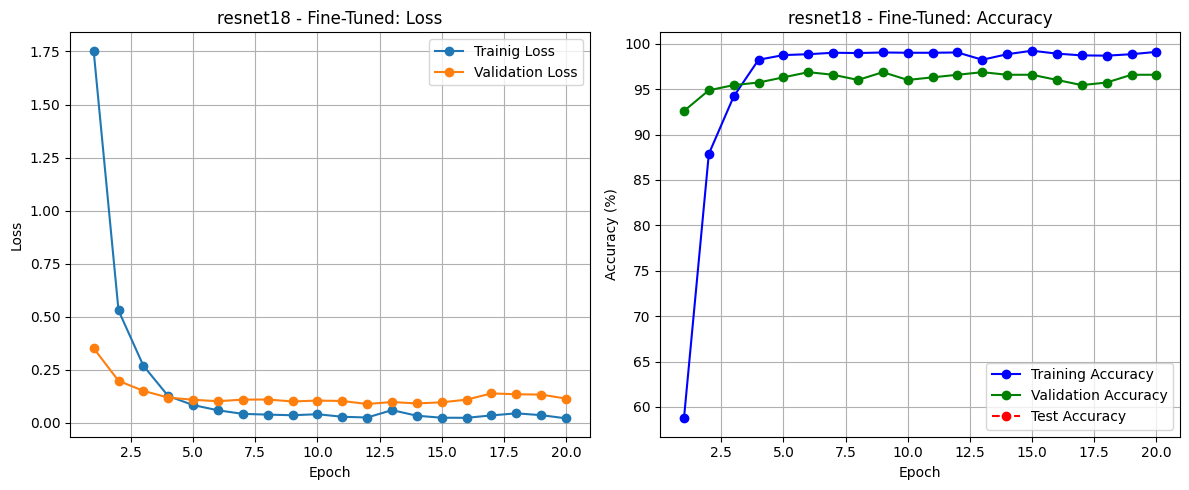

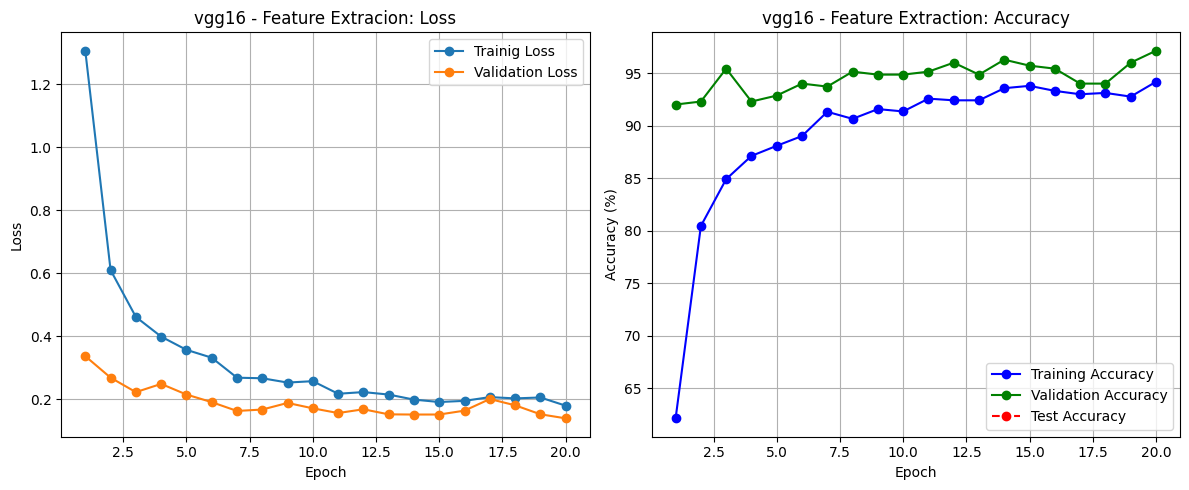

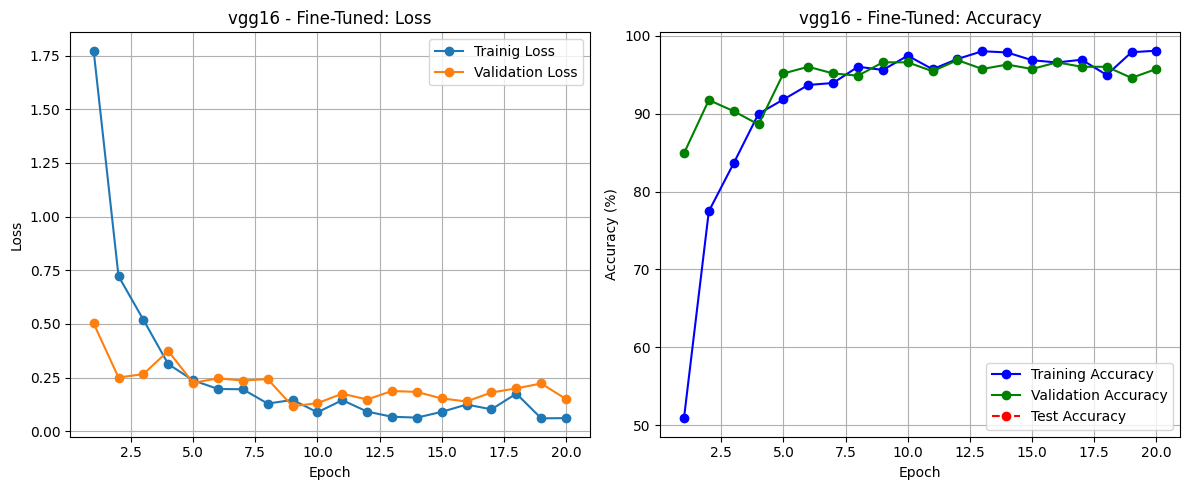

In [9]:
from pickle import NONE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20


def get_model(model_name, fine_tune):
  if model_name == "resnet18": # fc layer는 1개
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 36)
  elif model_name == "vgg16": #fc layer 3개 : 3번째 fc layer는 6번째
    model = models.vgg16(pretrained=True)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, 36)
  else:
    raise ValueError("Unsupported model")

  if not fine_tune: # fine tuning이 아니면 마지막 분류기만 재학습
    for param in model.parameters():
      param.requires_grad = False #freeze

    # For ResNet, unfreeze the fc layer
    if model_name == "resnet18":
      for param in model.fc.parameters():
        param.requires_grad = True
    # For VGG16, unfreeze the classifier[6] layer
    elif model_name == "vgg16":
        for param in model.classifier[6].parameters():
          param.requires_grad = True

  # fine tuning이면 전체 재학습; param.requires_grad = True (default)
  return model

def save_model(model, model_name, fine_tune):
  model_filename = f"{model_name}_{'fine_tuned' if fine_tune else 'feature_extraction'}.pth"
  torch.save(model.state_dict(), model_filename)
  print(f"Model saved as {model_filename}")

models_to_train = [("resnet18", False), ("resnet18", True), ("vgg16", False), ("vgg16", True)]
results = []


for model_name, fine_tune in models_to_train:
  model = get_model(model_name, fine_tune)
  learning_rate = 0.0001 if fine_tune else 0.001
  optimizer = optim.Adam(model.parameters(), lr = learning_rate)
  criterion = nn.CrossEntropyLoss()

  print(f"Training {model_name} - {'Fine-Tuning' if fine_tune else 'Feature Extraction'}")

  model.to(device)

  # 손실 및 정확도를 기록할 리스트
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  for epoch in range(num_epochs):
    epoch_start_time = datetime.datetime.now() # 학습 시작 시간 기록

    # training
    model.train()
    running_train_loss = 0.0
    correct_train = 0

    for data, label in trainloader:
      data, label = data.to(device), label.to(device)
      scores = model(data)
      loss = criterion(scores, label)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_train_loss += loss.item() * data.size(0)
      predicted = scores.argmax(dim=1)
      correct_train += predicted.eq(label).sum().item()

    train_loss = running_train_loss / len(trainloader.dataset)
    train_accuracy = 100. * correct_train / len(trainloader.dataset)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # validation
    model.eval()
    # all_preds = [] # 모델 예측값을 저장할 리스트
    # all_labels = [] # 실제 레이블을 저장할 리스트
    running_val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for data, label in valloader:
          data, label = data.to(device), label.to(device)
          scores = model(data)
          loss = criterion(scores, label)
          running_val_loss += loss.item() * data.size(0)

          predicted = scores.argmax(dim=1)
          correct_val += predicted.eq(label).sum().item()

          # # 예측값과 실제값 저장
          # all_preds.extend(predicted.cpu().numpy())
          # all_labels.extend(label.cpu().numpy())

    val_loss = running_val_loss / len(valloader.dataset)
    val_accuracy = 100. * correct_val / len(valloader.dataset)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Test 데이터에 대한 정확도 추가로 구하기
    model.eval()
    correct_test = 0
    total_test = 0

    epoch_end_time = datetime.datetime.now()

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    save_model(model, model_name, fine_tune)

    results.append({
        "model": model_name,
        "fine_tune": fine_tune,
        "epoch": epoch + 1,
        "start_time": epoch_start_time.strftime("%Y-%m-%d %H:%M:%S"),
        "end_time": epoch_end_time.strftime("%Y-%m-%d %H:%M:%S"),
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "test_accuracy": None
        })
  save_model(model, model_name, fine_tune)

  with torch.no_grad():
    for data, label in testloader:
      data, label = data.to(device), label.to(device)
      outputs = model(data)
      predicted = outputs.argmax(dim=1)
      correct_test += predicted.eq(label).sum().item()
      total_test += label.size(0)

  test_accuracy = 100. * correct_test / total_test
  print(f"Test Accuracy: {test_accuracy:.2f}%\n")

  results.append({
    "model": model_name,
    "fine_tune": fine_tune,
    "epoch": None,
    "start_time": None,
    "end_time": None,
    "train_loss": None,
    "train_accuracy": None,
    "val_loss": None,
    "val_accuracy": None,
    "test_accuracy": test_accuracy
    })

df = pd.DataFrame(results)

# CSV 파일로 저장
df.to_csv("results.csv", index=False)

# 모델별 학습 결과 시각화
unique_models = df['model'].unique()
fine_tune_options = df['fine_tune'].unique()

for model_name in unique_models:
  for fine_tune in fine_tune_options:
    subset = df[(df['model'] == model_name) & (df['fine_tune'] == fine_tune)]

    if subset.empty:
      continue

    epochs = subset["epoch"]

    plt.figure(figsize=(12,5))

    # loss 시각화
    plt.subplot(1,2,1)
    plt.plot(epochs, subset["train_loss"], 'o-', label='Trainig Loss')
    plt.plot(epochs, subset["val_loss"], 'o-', label='Validation Loss')
    plt.title(f'{model_name} - {"Fine-Tuned" if fine_tune else "Feature Extracion"}: Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Accuracy 시각화
    plt.subplot(1, 2, 2)
    plt.plot(epochs, subset["train_accuracy"], 'o-', color='blue', label='Training Accuracy')
    plt.plot(epochs, subset["val_accuracy"], 'o-', color='green', label='Validation Accuracy')
    plt.plot(epochs, subset["test_accuracy"], 'o-', color='red', linestyle="--", label='Test Accuracy')
    plt.title(f'{model_name} - {"Fine-Tuned" if fine_tune else "Feature Extraction"}: Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [10]:
df

,model,fine_tune,epoch,start_time,end_time,train_loss,train_accuracy,val_loss,val_accuracy,test_accuracy
0,resnet18,False,1.0,2025-03-28 07:12:29,2025-03-28 07:12:53,2.375837,43.884430,1.012959,81.766382,NaN
1,resnet18,False,2.0,2025-03-28 07:12:53,2025-03-28 07:13:19,1.168052,73.707865,0.583491,86.609687,NaN
2,resnet18,False,3.0,2025-03-28 07:13:19,2025-03-28 07:13:44,0.862923,79.390048,0.458444,88.888889,NaN
3,resnet18,False,4.0,2025-03-28 07:13:45,2025-03-28 07:14:10,0.712500,82.471910,0.378015,92.022792,NaN
4,resnet18,False,5.0,2025-03-28 07:14:10,2025-03-28 07:14:34,0.616966,84.783307,0.339878,92.307692,NaN
...,...,...,...,...,...,...,...,...,...,...
79,vgg16,True,17.0,2025-03-28 07:45:41,2025-03-28 07:46:07,0.102330,96.918138,0.180763,96.011396,NaN
80,vgg16,True,18.0,2025-03-28 07:46:09,2025-03-28 07:46:34,0.175493,94.959872,0.199826,96.011396,NaN
81,vgg16,True,19.0,2025-03-28 07:46:35,2025-03-28 07:47:02,0.060372,97.881220,0.222752,94.586895,NaN
82,vgg16,True,20.0,2025-03-28 07:47:03,2025-03-28 07:47:29,0.061418,98.073836,0.150035,95.726496,NaN


In [ ]:
df.to_csv("results.csv")

### 새로운 데이터 예측

In [11]:
model = models.resnet18(pretrained=False)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 36)

model.load_state_dict(torch.load("resnet18_fine_tuned.pth"))
model.eval()



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

image_path = "/content/apple.jpg"
image = Image.open(image_path)
image = transform(image)
image = image.unsqueeze(0) # 배치 차원 추가 (1, C, H, W)

with torch.no_grad():
  outputs = model(image)

predicted_class = outputs.argmax(dim=1).item()
print(f"예측된 클래스 인덱스: {predicted_class}")

print(f"모델이 예측한 클래스: {class_names[predicted_class]}")

예측된 클래스 인덱스: 0
모델이 예측한 클래스: apple
